In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
DATASET_PATH = "dataset/MovieSummaries/"
MOVIES = DATASET_PATH + "movie.metadata.tsv"
MOVIES_SUMMARIES = DATASET_PATH + "plot_summaries.txt"
MOVIES_CHARACTER = DATASET_PATH + "character.metadata.tsv"

df_movies = pd.read_csv(MOVIES, sep="\t", header=None)
df_movies.columns = [
        "Wikipedia_movie_ID", 
        "Freebase_movie_ID", 
        "Movie_name", 
        "Movie_release_date", 
        "Box_office_revenue", 
        "Runtime", 
        "Languages", 
        "Countries", 
        "Genres"
    ]

df_summaries = pd.read_csv(MOVIES_SUMMARIES, sep="\t", header=None)
df_summaries.columns = [
        "Wikipedia_movie_ID", 
        "Plot_summary"
    ]

df_character = pd.read_csv(MOVIES_CHARACTER, sep="\t", header=None)
df_character.columns = [
        "Wikipedia_movie_ID", 
        "Freebase_movie_ID", 
        "Movie_release_date", 
        "Character_name", 
        "Actor_dob", 
        "Actor_gender", 
        "Actor_height", 
        "Actor_ethnicity", 
        "Actor_name", 
        "Actor_age_at_release", 
        "Freebase_char_actor_map_ID", 
        "Freebase_character_ID", 
        "Freebase_actor_ID"
    ]

df_movies.head(10)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [24]:
# Size of the data
print(f"Size of df_movies: {df_movies.shape}")
print(f"Size of df_summaries: {df_summaries.shape}")
print(f"Size of df_character: {df_character.shape}")

Size of df_movies: (81741, 10)
Size of df_summaries: (42303, 2)
Size of df_character: (450669, 13)


In [31]:
# Find the intersection of movie IDs in both datasets
common_movies = df_movies["Wikipedia_movie_ID"].isin(df_summaries["Wikipedia_movie_ID"]).sum()

print(f"Number of movies in df_movies that are also in df_summaries: {common_movies}\n")
print(f"This represents {round(common_movies/df_movies.shape[0] * 100, 2)}% of df_movies and {round(common_movies/df_summaries.shape[0] * 100, 2)}% of df_summaries")

Number of movies in df_movies that are also in df_summaries: 42204

This represents 51.63% of df_movies and 99.77% of df_summaries


In [23]:
# Check for missing values
print("Missing values in df_movies:\n", df_movies.isna().sum(), "\n")
print("Missing values in df_summaries:\n", df_summaries.isna().sum(), "\n")
print("Missing values in df_character:\n", df_character.isna().sum(), "\n")

Missing values in df_movies:
 Wikipedia_movie_ID        0
Freebase_movie_ID         0
Movie_name                0
Movie_release_date    42369
Box_office_revenue    73340
Runtime               20450
Languages                 0
Countries                 0
Genres                    0
Year                  42369
dtype: int64 

Missing values in df_summaries:
 Wikipedia_movie_ID    0
Plot_summary          0
dtype: int64 

Missing values in df_character:
 Wikipedia_movie_ID                 0
Freebase_movie_ID                  0
Movie_release_date              9995
Character_name                257875
Actor_dob                     106145
Actor_gender                   45609
Actor_height                  295845
Actor_ethnicity               344611
Actor_name                      1228
Actor_age_at_release          158113
Freebase_char_actor_map_ID         0
Freebase_character_ID         257865
Freebase_actor_ID                815
dtype: int64 



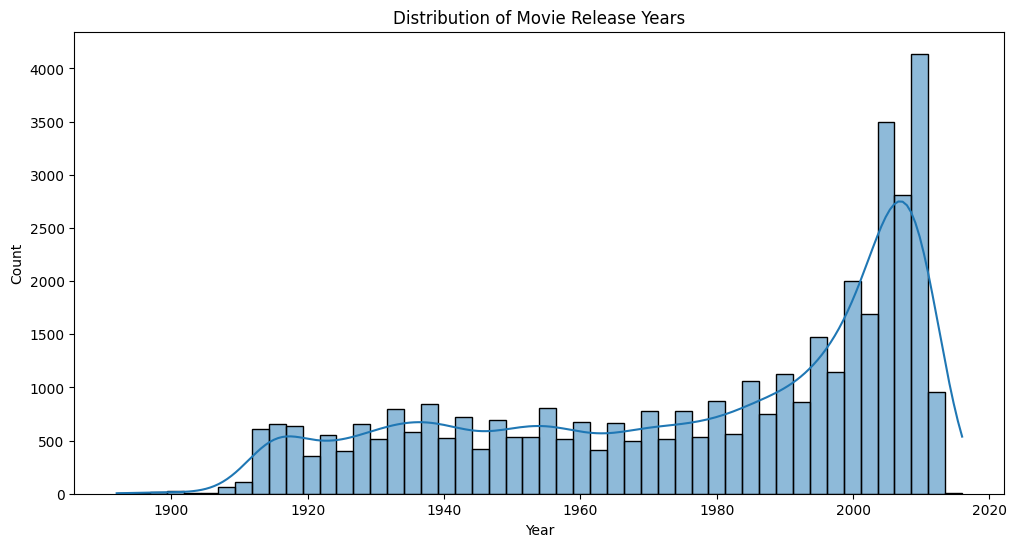

In [37]:
# Analyze distribution of movie release dates
df_movies["Movie_release_date"] = pd.to_datetime(df_movies["Movie_release_date"], errors="coerce")
df_movies["Year"] = df_movies["Movie_release_date"].dt.year
plt.figure(figsize=(12, 6))
sns.histplot(df_movies["Year"].dropna(), bins=50, kde=True)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Year")
plt.show()

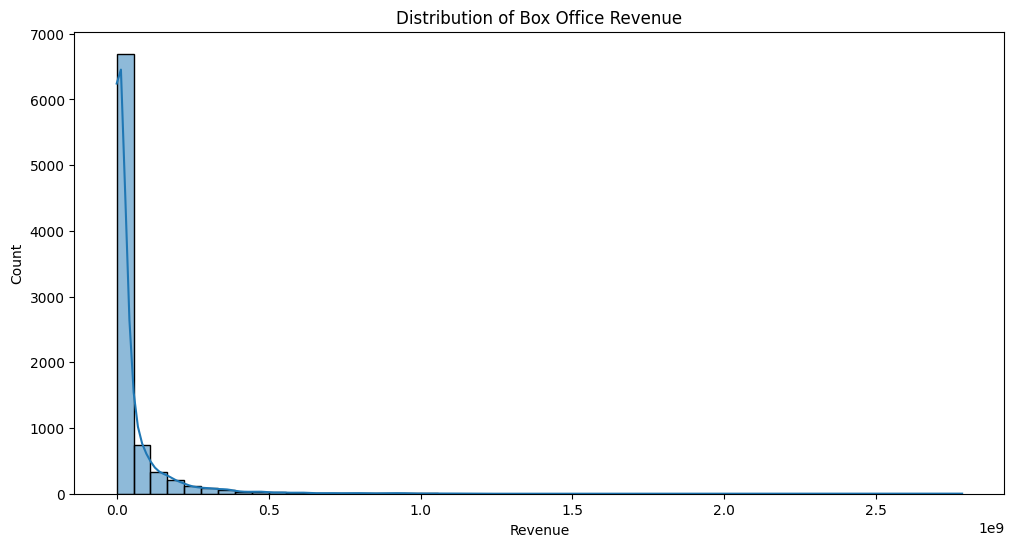

In [38]:
# Analyze distribution of box office revenue
plt.figure(figsize=(12, 6))
sns.histplot(df_movies["Box_office_revenue"].dropna(), bins=50, kde=True)
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Revenue")
plt.show()